# Evolutionary Algorithm

## Evolving Strings

In [1]:
import random

import matplotlib.pyplot as plt

alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWZXYZ,.! "
target = "Hello World!"


class Individual:
    def __init__(self, string, fitness=0):
        self.string = string
        self.fitness = fitness

In [6]:
from difflib import SequenceMatcher


def similar(a, b):
    """returns 1 if exact, else a ratio of similarity"""
    return SequenceMatcher(None, a, b).ratio()


def spawn_population(length=256, size=100):
    pop = []
    for i in range(size):
        string = "".join(random.choices(alphabet, k=length))
        individual = Individual(string)
        pop.append(individual)
    return pop

In [11]:
def recombine(p1_, p2_):
    p1 = p1_.string
    p2 = p2_.string
    child1 = []
    child2 = []

    cross_pt = random.randint(0, len(p1))
    child1.extend(p1[0:cross_pt])
    child1.extend(p2[cross_pt:])
    child2.extend(p2[0:cross_pt])
    child2.extend(p1[cross_pt:])
    c1 = Individual("".join(child1))
    c2 = Individual("".join(child2))
    return c1, c2

In [34]:
def evaluate_population(pop, target):
    avg_fit = 0
    for i in range(len(pop)):
        fit = similar(pop[i].string, target)
        pop[i].fitness = fit
        avg_fit += fit
    avg_fit /= len(pop)
    return pop, avg_fit

In [35]:
def mutate(x, mut_rate=0.01):
    new_x_ = []
    for char in x.string:
        if random.random() < mut_rate:
            new_x_.extend(random.choices(alphabet, k=1))
        else:
            new_x_.append(char)
    new_x = Individual("".join(new_x_))
    return new_x

In [39]:
def next_generation(pop, size=100, length=26, mut_rate=0.01):
    new_pop = []
    while len(new_pop) < size:
        parents = random.choices(pop, k=2, weights=[x.fitness for x in pop])
        offspring_ = recombine(parents[0], parents[1])
        child1 = mutate(offspring_[0], mut_rate=mut_rate)
        child2 = mutate(offspring_[1], mut_rate=mut_rate)
        child1.fitness = similar(child1.string, target)
        child2.fitness = similar(child2.string, target)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

In [40]:
from tqdm.autonotebook import tqdm

num_generations = 150
population_size = 900
str_len = len(target)
mutation_rate = 0.00001

pop_fit = []
pop = spawn_population(size=population_size, length=str_len)
for gen in tqdm(range(num_generations)):
    pop, avg_fit = evaluate_population(pop, target)
    pop_fit.append(avg_fit)
    new_pop = next_generation(
        pop, size=population_size, length=str_len, mut_rate=mutation_rate
    )
    pop = new_pop

pop.sort(key=lambda x: x.fitness, reverse=True)
pop[0].string

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:13<00:00, 10.88it/s]


'Helloorldr!l'

In [41]:
for p in pop[:10]:
    print(p.string, p.fitness)

Helloorldr!l 0.8333333333333334
Helloorld!ud 0.8333333333333334
Helloorld!!d 0.8333333333333334
Helloorld!!d 0.8333333333333334
Hello rld!!o 0.8333333333333334
Helloorld!!d 0.8333333333333334
Helloorld!!l 0.8333333333333334
Helloorld!!o 0.8333333333333334
Helloorldr!o 0.8333333333333334
Helloorld!!o 0.8333333333333334


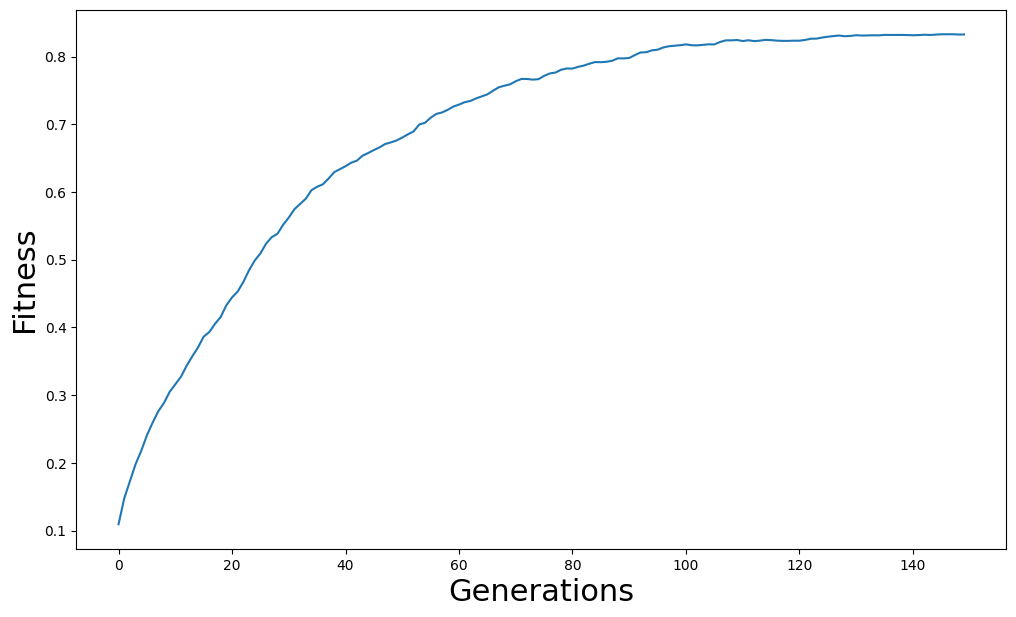

In [49]:
plt.figure(figsize=(12, 7))
plt.xlabel("Generations", fontsize=22)
plt.ylabel("Fitness", fontsize=22)
plt.plot(pop_fit)

## CartPole

Total number of parameters:

In [51]:
4 * 25 + 25 + 10 * 25 + 10 + 2 * 10 + 2

407

In [62]:
import numpy as np
import torch


def model(x, unpacked_params):
    """
    a 3-layer neural network
    the output is a log probabilities over actions
    """
    l1, b1, l2, b2, l3, b3 = unpacked_params
    y = torch.nn.functional.linear(x, l1, b1)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y, l2, b2)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y, l3, b3)
    y = torch.log_softmax(y, dim=0)
    return y


def unpack_params(params, layers=[(25, 4), (10, 25), (2, 10)]):
    unpacked_params = []
    e = 0
    for i, l in enumerate(layers):
        s, e = e, e + np.prod(l)
        weights = params[s:e].view(l)
        s, e = e, e + l[0]
        bias = params[s:e]
        unpacked_params.extend([weights, bias])
    return unpacked_params

In [45]:
def spawn_population(N=50, size=407):
    pop = []
    for i in range(N):
        vec = torch.randn(size) / 2.0
        fit = 0
        p = {"params": vec, "fitness": fit}
        pop.append(p)
    return pop

In [64]:
def recombine(x1, x2):
    """shuffles around information that already exists"""
    x1 = x1["params"]
    x2 = x2["params"]
    l = x1.shape[0]
    split_pt = np.random.randint(l)
    child1 = torch.zeros(l)
    child2 = torch.zeros(l)

    child1[0:split_pt] = x1[0:split_pt]
    child1[split_pt:] = x2[split_pt:]
    child2[0:split_pt] = x2[0:split_pt]
    child2[split_pt:] = x1[split_pt:]
    c1 = {"params": child1, "fitness": 0.0}
    c2 = {"params": child2, "fitness": 0.0}
    return c1, c2

In [52]:
def mutate(x, rate=0.01):
    """mutation is the only source of new genetic information in each generation"""
    x_ = x["params"]
    num_to_change = int(rate * x_.shape[0])
    idx = np.random.randint(low=0, high=x_.shape[0], size=(num_to_change,))
    x_[idx] = torch.randn(num_to_change) / 10.0
    x["params"] = x_
    return x

In [56]:
import gymnasium as gym

env = gym.make("CartPole-v1")


def test_model(agent):
    obs, _ = env.reset()
    state = torch.from_numpy(obs).float()
    score = 0
    done = False
    while not done:
        params = unpack_params(agent["params"])
        probs = model(state, params)
        action = torch.distributions.Categorical(probs=probs).sample()
        state_, reward, done, truncated, info = env.step(action.item())
        state = torch.from_numpy(state_).float()
        score += 1
    return score

In [58]:
def evaluate_population(pop):
    tot_fit = 0
    lp = len(pop)
    for agent in pop:
        score = test_model(agent)
        agent["fitness"] = score
        tot_fit += score
    avg_fit = tot_fit / lp
    return pop, avg_fit

In [60]:
def next_generation(pop, mut_rate=0.001, tournament_size=0.2):
    new_pop = []
    lp = len(pop)
    while len(new_pop) < len(pop):
        rids = np.random.randint(low=0, high=lp, size=(int(tournament_size * lp)))
        batch = np.array([[i, x["fitness"]] for (i, x) in enumerate(pop) if i in rids])
        scores = batch[batch[:, 1].argsort()]
        i0, i1 = int(scores[-1][0]), int(scores[-2][0])
        parent0, parent1 = pop[i0], pop[i1]
        offspring_ = recombine(parent0, parent1)
        child1 = mutate(offspring_[0], rate=mut_rate)
        child2 = mutate(offspring_[1], rate=mut_rate)
        offspring = [child1, child2]
        new_pop.extend(offspring)
    return new_pop

In [66]:
from tqdm.autonotebook import tqdm

num_generations = 25
population_size = 500
mutation_rate = 0.01
pop_fit = []
pop = spawn_population(N=population_size, size=407)

for i in tqdm(range(num_generations)):
    pop, avg_fit = evaluate_population(pop)
    pop_fit.append(avg_fit)
    pop = next_generation(pop, mut_rate=mutation_rate, tournament_size=0.2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [17:07<00:00, 41.10s/it]


In [ ]:
def running_mean(x, n=5):
    conv = np.ones(n)
    y = np.zeros(x.shape[0] - n)
    for i in range(x.shape[0] - n):
        y[i] = (conv @ x[i : i + n]) / n
    return y

In [ ]:
plt.figure(figsize=(12, 7))
plt.xlabel("Generations", fontsize=22)
plt.ylabel("Score", fontsize=22)
plt.plot(running_mean(np.array(pop_fit), 3))